<a href="https://colab.research.google.com/github/ZEBAAFROZ/SHAP/blob/main/SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 10.5 MB/s eta 0:00:00


In [5]:
import tensorflow.keras as keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import requests
from skimage.segmentation import slic
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import skimage.io
import skimage.transform
import warnings

In [8]:
# load model data
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
feature_names = r.json()
model = VGG16()

553467096/553467096 [==============================] - 25s 0us/step


In [3]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


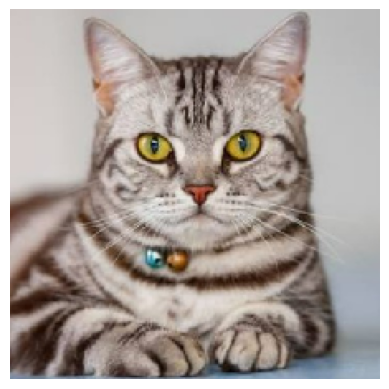

In [16]:
# load an image
file = "/content/cat.jpg"
img = image.load_img(file, target_size=(224, 224))
img_orig = image.img_to_array(img)
plt.imshow(img);
plt.axis('off');

In [25]:
img_orig = preprocess_input(np.expand_dims(img_orig.copy(), axis=0))

In [27]:
preds = model.predict(img_orig)
predicted_class_index = np.argmax(preds)
predicted_class_label = decode_predictions(preds, top=1)[0][0][1]
predicted_probability = np.max(preds)

35363/35363 [==============================] - 0s 0us/step


In [28]:
print("Predicted Class Label: ", predicted_class_label)
print("Prediction Probability: {:.2f}".format(predicted_probability))

Predicted Class Label:  tabby
Prediction Probability: 0.50


<Axes: title={'center': 'Top 10 Predictions'}>

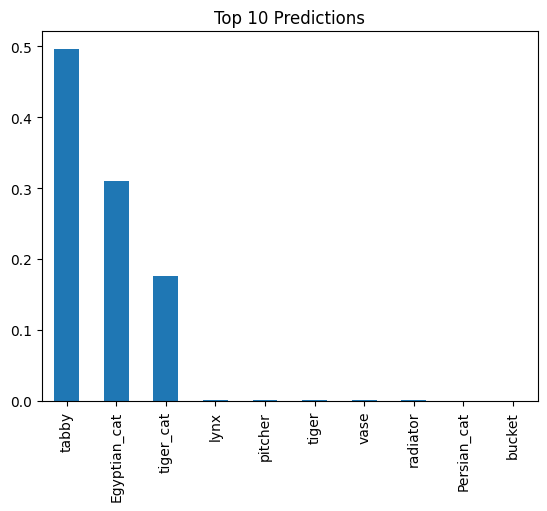

In [29]:
top_preds = np.argsort(-preds)
inds = top_preds[0]
top_10_pred=pd.Series(data={feature_names[str(inds[i])][1]:preds[0, inds[i]] for i in range(10)})
top_10_pred.plot(kind='bar', title='Top 10 Predictions')

In [17]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):

    return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

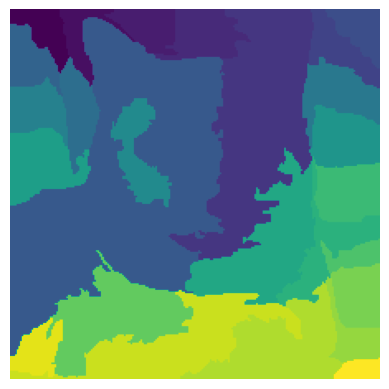

In [35]:
segments_slic = slic(img, n_segments=100, compactness=1, sigma=1)
plt.imshow(segments_slic);
plt.axis('off');

In [19]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

1/1 [==============================] - 8s 8s/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 9s 149ms/step


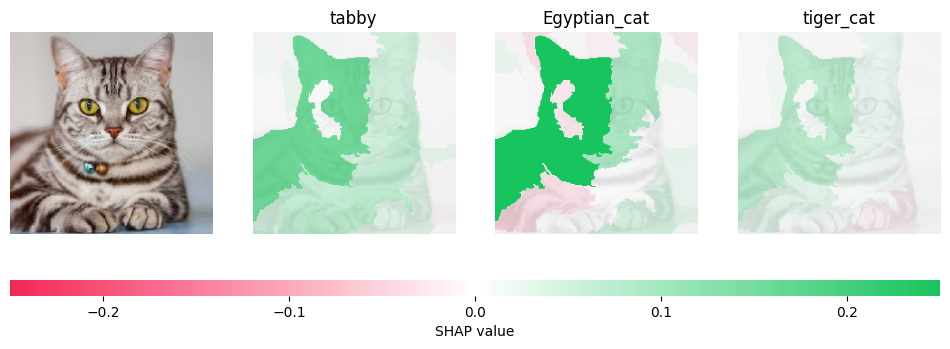

In [36]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))

cm = LinearSegmentedColormap.from_list("shap", colors)
# Visualize the explanations
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()